In [19]:
import os
import sys
import pandas as pd
import re

In [20]:

languages = ["spanish", "german", "french"]
train_dfs = []
for lang in languages:
    df = pd.read_csv(f"../../data/{lang}/train.csv")
    df["language"] = lang
    train_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)

val_dfs = []
for lang in languages:
    df = pd.read_csv(f"../../data/{lang}/valid.csv")
    df["language"] = lang
    val_dfs.append(df)

val_df = pd.concat(val_dfs, ignore_index=True)

test_dfs = []
for lang in languages:
    df = pd.read_csv(f"../../data/{lang}/test.csv")
    df["language"] = lang
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)


In [21]:
# from sklearn.model_selection import train_test_split

# train_df, _ = train_test_split(
#     train_df,
#     test_size = 0.6 ,
#     stratify = train_df['label'],
#     random_state = 42
# )

In [22]:
train_df = train_df[train_df["label"] != "neutral"]
test_df  = test_df[test_df["label"]  != "neutral"]
val_df   = val_df[val_df["label"]   != "neutral"]

mapping = {'negative': 0, 'positive': 1}

# Create a new column with mapped values
train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [23]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = rt_pattern.sub("", text)
    text = url_pattern.sub(" URL ", text)
    text = mention_pattern.sub(" @usuario ", text)
    text = hashtag_pattern.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text



train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [24]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from datasets import Dataset

model_name = "bert-base-multilingual-uncased"
tok = BertTokenizer.from_pretrained(model_name)
MAX_LEN = 128

def tokenize(batch):
    return tok(
        batch["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)


/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)
test_dataset = SentimentDataset(test_encodings, test_df["sentiment_num"].values)

In [26]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle = True)
#change number of labels based on keep/drop neutral class
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 25%|██▌       | 230/920 [03:03<09:47,  1.17it/s]

{'loss': 0.5324, 'grad_norm': 6.775221347808838, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


                                                 
 25%|██▌       | 230/920 [03:12<09:47,  1.17it/s]

{'eval_loss': 0.4285488426685333, 'eval_runtime': 9.4241, 'eval_samples_per_second': 68.76, 'eval_steps_per_second': 4.351, 'epoch': 1.0}


 50%|█████     | 460/920 [06:53<07:25,  1.03it/s]

{'loss': 0.3169, 'grad_norm': 16.140600204467773, 'learning_rate': 1e-05, 'epoch': 2.0}


                                                 
 50%|█████     | 460/920 [07:04<07:25,  1.03it/s]

{'eval_loss': 0.5018208622932434, 'eval_runtime': 10.8763, 'eval_samples_per_second': 59.579, 'eval_steps_per_second': 3.77, 'epoch': 2.0}


 75%|███████▌  | 690/920 [10:58<03:52,  1.01s/it]

{'loss': 0.1898, 'grad_norm': 27.3441162109375, 'learning_rate': 5e-06, 'epoch': 3.0}


                                                 
 75%|███████▌  | 690/920 [11:10<03:52,  1.01s/it]

{'eval_loss': 0.6173702478408813, 'eval_runtime': 11.5953, 'eval_samples_per_second': 55.885, 'eval_steps_per_second': 3.536, 'epoch': 3.0}


100%|██████████| 920/920 [15:08<00:00,  1.05it/s]

{'loss': 0.1195, 'grad_norm': 8.985343933105469, 'learning_rate': 0.0, 'epoch': 4.0}


                                                 
100%|██████████| 920/920 [15:19<00:00,  1.05it/s]

{'eval_loss': 0.7855544686317444, 'eval_runtime': 10.9285, 'eval_samples_per_second': 59.295, 'eval_steps_per_second': 3.752, 'epoch': 4.0}


100%|██████████| 920/920 [15:21<00:00,  1.00s/it]

{'train_runtime': 921.3588, 'train_samples_per_second': 15.968, 'train_steps_per_second': 0.999, 'train_loss': 0.2896389691726021, 'epoch': 4.0}


TrainOutput(global_step=920, training_loss=0.2896389691726021, metrics={'train_runtime': 921.3588, 'train_samples_per_second': 15.968, 'train_steps_per_second': 0.999, 'total_flos': 967722461614080.0, 'train_loss': 0.2896389691726021, 'epoch': 4.0})

In [27]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 41/41 [00:10<00:00,  3.74it/s]

{'eval_loss': 0.7855544686317444, 'eval_runtime': 11.0096, 'eval_samples_per_second': 58.858, 'eval_steps_per_second': 3.724, 'epoch': 4.0}


In [28]:
predictions = trainer.predict(val_dataset)

100%|██████████| 41/41 [00:11<00:00,  3.46it/s]


In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

val_pred = trainer.predict(val_dataset)

val_logits = val_pred.predictions
val_y_pred = np.argmax(val_logits, axis=1)

val_y_true = val_df["sentiment_num"].to_numpy()
val_lang_array = val_df["language"].to_numpy()

print("len(val_y_true)    =", len(val_y_true))
print("len(val_lang_array)=", len(val_lang_array))
print("len(val_y_pred)    =", len(val_y_pred))
assert len(val_y_true) == len(val_lang_array) == len(val_y_pred)

print("=== Overall validation performance (all 3 languages) ===")
val_overall_acc = accuracy_score(val_y_true, val_y_pred)
val_overall_f1_macro = f1_score(val_y_true, val_y_pred, average="macro")

print("Accuracy:", val_overall_acc)
print("F1 (macro):", val_overall_f1_macro)

print("\nClassification report (validation, all languages combined):")
print(
    classification_report(
        val_y_true,
        val_y_pred,
        target_names=["negative", "positive"]
    )
)

print("\nConfusion matrix (validation, all languages) [rows=true, cols=pred]:")
print(confusion_matrix(val_y_true, val_y_pred))

val_lang_f1s = []

for lang in np.unique(val_lang_array):
    mask = (val_lang_array == lang)
    lang_true = val_y_true[mask]
    lang_pred = val_y_pred[mask]

    print(f"\n\n===== Validation – Language: {lang} =====")
    lang_acc = accuracy_score(lang_true, lang_pred)
    lang_f1 = f1_score(lang_true, lang_pred, average="macro")
    val_lang_f1s.append(lang_f1)

    print("Accuracy:", lang_acc)
    print("F1 (macro):", lang_f1)

    print("\nClassification report:")
    print(
        classification_report(
            lang_true,
            lang_pred,
            target_names=["negative", "positive"]
        )
    )

    print("Confusion matrix [rows=true, cols=pred]:")
    print(confusion_matrix(lang_true, lang_pred))

if len(val_lang_f1s) > 0:
    avg_val_lang_f1 = np.mean(val_lang_f1s)
    print("\n=== Validation Macro F1 averaged over languages (3-language mean) ===")
    print("Validation language-level macro F1:", avg_val_lang_f1)


100%|██████████| 41/41 [00:12<00:00,  3.41it/s]


len(val_y_true)    = 648
len(val_lang_array)= 648
len(val_y_pred)    = 648
=== Overall validation performance (all 3 languages) ===
Accuracy: 0.8194444444444444
F1 (macro): 0.8194405744293216

Classification report (validation, all languages combined):
              precision    recall  f1-score   support

    negative       0.82      0.81      0.82       324
    positive       0.82      0.82      0.82       324

    accuracy                           0.82       648
   macro avg       0.82      0.82      0.82       648
weighted avg       0.82      0.82      0.82       648


Confusion matrix (validation, all languages) [rows=true, cols=pred]:
[[264  60]
 [ 57 267]]


===== Validation – Language: french =====
Accuracy: 0.8194444444444444
F1 (macro): 0.8193476442709785

Classification report:
              precision    recall  f1-score   support

    negative       0.83      0.80      0.82       108
    positive       0.81      0.84      0.82       108

    accuracy                       

Test Dataset

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

pred = trainer.predict(test_dataset)
logits = pred.predictions
y_pred = np.argmax(logits, axis=1)

y_true = test_df["sentiment_num"].to_numpy()
lang_array = test_df["language"].to_numpy()


print("=== Overall test performance (all 3 languages) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))

print("\nClassification report (all languages):")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["negative", "positive"],  
    )
)

print("\nConfusion matrix (all languages) [rows=true, cols=pred]:")
print(confusion_matrix(y_true, y_pred))


for lang in np.unique(lang_array):
    mask = (lang_array == lang)  

    lang_true = y_true[mask]
    lang_pred = y_pred[mask]

    print(f"\n===== Language: {lang} =====")
    print("Accuracy:", accuracy_score(lang_true, lang_pred))
    print("F1 (macro):", f1_score(lang_true, lang_pred, average="macro"))

    print("\nClassification report:")
    print(
        classification_report(
            lang_true,
            lang_pred,
            target_names=["negative", "positive"],
        )
    )

    print("Confusion matrix [rows=true, cols=pred]:")
    print(confusion_matrix(lang_true, lang_pred))


100%|██████████| 109/109 [00:33<00:00,  3.23it/s]

=== Overall test performance (all 3 languages) ===
Accuracy: 0.8
F1 (macro): 0.7999904870624048

Classification report (all languages):
              precision    recall  f1-score   support

    negative       0.80      0.79      0.80       870
    positive       0.80      0.81      0.80       870

    accuracy                           0.80      1740
   macro avg       0.80      0.80      0.80      1740
weighted avg       0.80      0.80      0.80      1740


Confusion matrix (all languages) [rows=true, cols=pred]:
[[690 180]
 [168 702]]

===== Language: french =====
Accuracy: 0.8120689655172414
F1 (macro): 0.8118670749526096

Classification report:
              precision    recall  f1-score   support

    negative       0.83      0.78      0.81       290
    positive       0.79      0.84      0.82       290

    accuracy                           0.81       580
   macro avg       0.81      0.81      0.81       580
weighted avg       0.81      0.81      0.81       580

Confusion matri

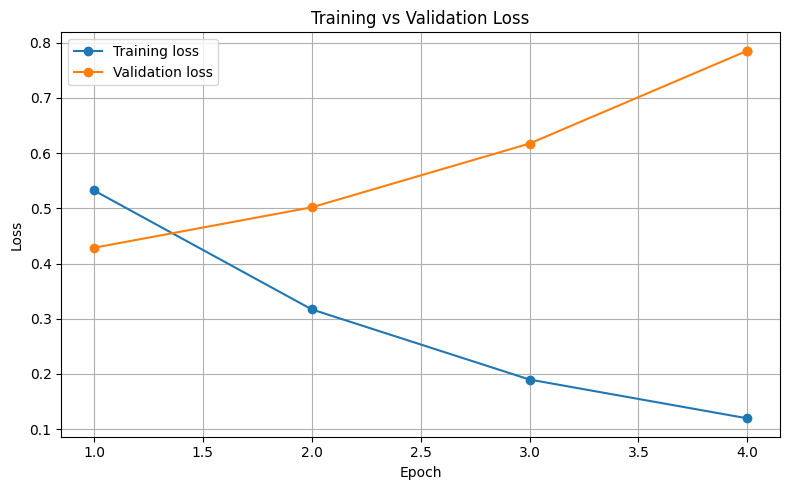

In [31]:
import matplotlib.pyplot as plt

# After training:
# trainer.train()

logs = pd.DataFrame(trainer.state.log_history)

# Separate train and eval logs
train_logs = logs[logs["loss"].notna()][["epoch", "loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_logs["epoch"], train_logs["loss"], marker="o", label="Training loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()